<h1><center><font color = 'blue'>AMSUA N18 - Exploratory Data Analysis</font></center></h1>

In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgbm
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats

### Import

In [2]:
df = pd.read_hdf('Data/amsua1200_n18_ch14.h5')

### Split inputs and outputs

In [3]:
X = df.drop(['DATETIME', 'IMPACT', 'OMF'], axis=1)
y = df['IMPACT']/df['OMF']

cols_2D = [col for col in X.columns if not any(char.isdigit() for char in col)]

### Explore y (sensitivity)

In [4]:
y.describe()

count    3.686530e+05
mean     4.962583e-09
std      6.723359e-07
min     -7.261009e-06
25%     -2.804551e-07
50%      3.456075e-09
75%      2.886824e-07
max      7.194673e-06
dtype: float64

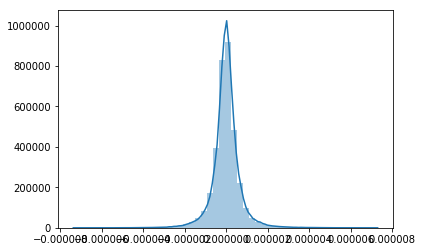

In [5]:
sns.distplot(y)

In [6]:
abs(y).describe()

count    3.686530e+05
mean     4.401306e-07
std      5.082762e-07
min      6.513701e-13
25%      1.261056e-07
50%      2.845859e-07
75%      5.620054e-07
max      7.261009e-06
dtype: float64

### y correlations with X variables 

In [7]:
y_corr = X.corrwith(y, axis=0)
print('\n5 largest corr with y:\n{}'.format(y_corr.nlargest()))
print('\n5 smallest corr with y:\n{}'.format(y_corr.nsmallest()))


5 largest corr with y:
u_0.185          0.018368
u_0.14           0.017507
qltot_727.369    0.016966
qltot_702.925    0.016640
u_0.245          0.015642
dtype: float64

5 smallest corr with y:
lon         -0.032839
LONGITUDE   -0.032836
u_100.514   -0.023579
u_118.25    -0.022960
u_72.558    -0.021462
dtype: float64


### Train and predict (Linear Regression & Gradient Boosting)

In [8]:
# split train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [9]:
# train Linear Regression
lr = LinearRegression()
lr.fit(X_train[cols_2D], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
# train Gradient Boosting
gbm = lgbm.LGBMRegressor(objective='regression', n_estimators=300, learning_rate=0.1, random_state=10)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=('train', 'test'),
    eval_metric='l2',
    early_stopping_rounds=20,
    feature_name=X_train.columns.tolist(),
    verbose=False
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=300,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=10,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [11]:
# predict LR
lr_pred = lr.predict(X_test[cols_2D])

In [12]:
# predict GBM
gbm_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

### Results

#### Linear Regression

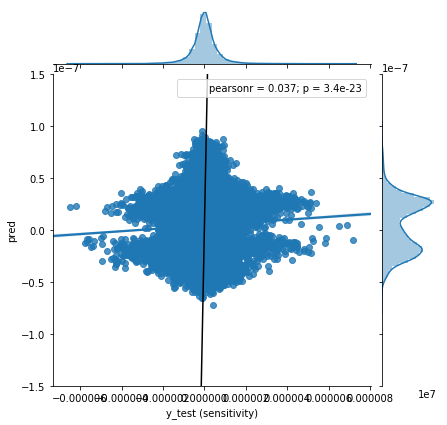

In [13]:
ax = sns.jointplot(x=y_test , y=lr_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.00000015, 0.00000015)
# add bissectrice (in black)
plt.plot([-0.00000015, 0.00000015], [-0.00000015, 0.00000015], 'k-')
plt.show()

#### Gradient Boosting

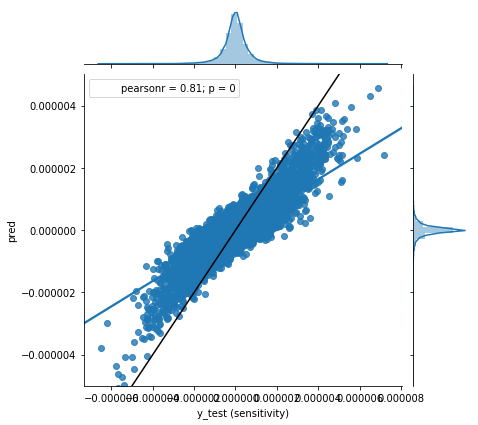

In [14]:
ax = sns.jointplot(x=y_test , y=gbm_pred, kind="reg")
ax.annotate(stats.pearsonr)
ax.set_axis_labels(xlabel='y_test (sensitivity)', ylabel='pred')
# fix y axis limits
ax.ax_marg_y.set_ylim(-0.000005, 0.000005)
# add bissectrice (in black)
plt.plot([-0.00001, 0.00001], [-0.00001, 0.00001], 'k-')
plt.show()

#### Mean Squared Error

In [15]:
print('Only zeros MSE: {0:.4g}' .format(mean_squared_error(y_test, [0]*len(y_test))))
print('AMSUA LR MSE:   {0:.4g}' .format(mean_squared_error(y_test, lr_pred)))
print('AMSUA GBM MSE:  {0:.4g}' .format(mean_squared_error(y_test, gbm_pred)))

Only zeros MSE: 4.513e-13
AMSUA LR MSE:   4.506e-13
AMSUA GBM MSE:  1.98e-13


#### Compute statistics about real sensitivity and pred sensitivity ratio

In [16]:
ratio = pd.Series(y_test/gbm_pred)
ratio.describe()

count     73731.000000
mean          0.638214
std         668.628851
min     -111752.868076
25%          -0.473618
50%           1.693702
75%           4.147958
max       83043.947690
dtype: float64

#### Display ratio pdf

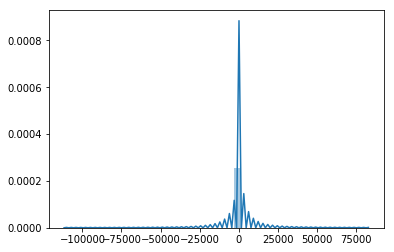

In [17]:
ax = sns.distplot(ratio, norm_hist=True)

#### % of ratio values between ]-3:3[

In [18]:
print('{0:.2f}%' .format(len(ratio[(ratio > -3) & (ratio < 3)])/len(ratio)*100))

51.78%


#### Display ratio between ]-3:3[ pdf

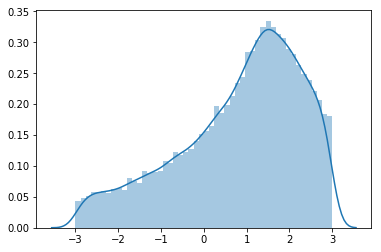

In [19]:
filtered = ratio[(ratio > -3) & (ratio < 3)]
ax = sns.distplot(filtered)

#### % of ratio values between ]0.5:1.5[

In [20]:
print('{0:.2f}%' .format(len(ratio[(ratio > 0.5) & (ratio < 1.5)])/len(ratio)*100))

13.87%


#### % of ratio negative sign

In [21]:
print('{0:.2f}%' .format(len(ratio[ratio < 0])/len(ratio)*100))

28.34%


#### % of ratio values ≈ 0

In [22]:
print('{0:.2f}%' .format(len(ratio[abs(ratio) < 1e-3])/len(ratio)*100))

0.02%
